In [ ]:
# Future imports
from __future__ import annotations

# Standard library imports
import csv
import os
import sys
import warnings
from typing import Set

# Third-party imports
import ast
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import soundfile as sf
import tensorflow as tf
import torch
import whisper
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm
import re
import unicodedata

In [2]:
# Read the input CSV file
df = pd.read_csv("C:/Users/yingx/OneDrive/Documents/GitHub/Capstone/data/static_annotations_averaged_songs_1_2000.csv")

# Define a function to determine emotion
def get_emotion(row):
    val = row["valence_mean"]
    aro = row["arousal_mean"]

    if val < 4.9 and aro < 4.9:
        return "Sad"
    elif val < 4.9 and aro >= 4.9:
        return "Anger"
    elif val >= 4.9 and aro < 4.9:
        return "Relaxed"
    elif val >= 4.9 and aro >= 4.9:
        return "Happy"
    else:
        print("Error in determining emotion for row:", row)
        return "Unknown"

# Apply the function to each row
df["emotion"] = df.apply(get_emotion, axis=1)

# Print counts for each emotion
print("Emotion counts:")
print(df["emotion"].value_counts())

# Create a new DataFrame with only id and emotion
output = df[["song_id", "emotion"]].rename(columns={"song_id": "id"})

# Save to a new CSV file
output.to_csv("emotion2.csv", index=False)

print("emotion2.csv has been created successfully!")


Emotion counts:
emotion
Happy      666
Sad        623
Relaxed    233
Anger      222
Name: count, dtype: int64
emotion2.csv has been created successfully!


In [ ]:
# Load model Whisper model
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

print(f"Loading Whisper model 'large' on {device} (this may take a while)...")
model = whisper.load_model("large", device=device)
print("Model loaded.")

In [ ]:
# Transcribe audio files and save to CSV
DATA_DIR = r"C:/Users/yingx/data/Output"
OUTPUT_CSV = r"C:/Users/yingx/data/transcription.csv"

def read_processed_ids(path: str) -> Set[int]:
    if not os.path.exists(path):
        return set()
    ids = set()
    try:
        with open(path, newline="", encoding="utf-8") as f:
            reader = csv.reader(f)a
            header = next(reader, None)
            for row in reader:
                if not row:
                    continue
                try:
                    ids.add(int(row[0]))
                except Exception:
                    continue
    except Exception:
        return set()
    return ids

# Set parameters
START = 1
END = 2058

processed = read_processed_ids(OUTPUT_CSV)
if processed:
    print(f"Found {len(processed)} already-processed ids in {OUTPUT_CSV}; these will be skipped.")

write_header = not os.path.exists(OUTPUT_CSV)
outdir = os.path.dirname(OUTPUT_CSV)
if outdir and not os.path.exists(outdir):
    os.makedirs(outdir, exist_ok=True)

with open(OUTPUT_CSV, "a", newline="", encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    if write_header:
        writer.writerow(["id", "transcription"])

    for i in range(START, END + 1):
        if i in processed:
            continue
        
        filename = f"{i}_vocals.wav"
        path = os.path.join(DATA_DIR, filename)
        if not os.path.exists(path):
            continue

        try:
            result = model.transcribe(path)
            text = result.get("text", "").strip()
        except Exception as e:
            print(f"Error transcribing {path}: {e}")
            text = ""

        writer.writerow([i, text])
        try:
            csvfile.flush()
            os.fsync(csvfile.fileno())
        except Exception:
            pass

        if i % 100 == 0:
            print(f"Processed up to {i}")

print(f"Done. Transcriptions written (appended) to: {OUTPUT_CSV}")

In [3]:
# Merge features.csv, transcription.csv, static_annotations_averaged_songs.csv, and emotion.csv into a singular CSV file

# Read csv
features_df = pd.read_csv(r'C:/Users/yingx/data/features.csv')
transcription_df = pd.read_csv(r'C:/Users/yingx/data/transcription.csv')
emotion_df = pd.read_csv(r'C:/Users/yingx/OneDrive/Documents/GitHub/Capstone/emotion2.csv')

# Merge on 'id' cloumn
merged_df = features_df.merge(transcription_df, on='id', how='left').merge(emotion_df, on='id', how='left')

# Save the merged DataFrame to a new CSV file
merged_df.to_csv(r'C:/Users/yingx/data/merged_data.csv', index=False)
print("Data merged successfully into merged_data.csv")


Data merged successfully into merged_data.csv


In [4]:
# Split the merged data into training and testing sets
# 1. Read the merged data
merged_df = pd.read_csv(r'C:/Users/yingx/data/merged_data.csv')
# 2. Keep only rows where emotion is not NaN (only labeled songs)
labeled_df = merged_df.dropna(subset=['emotion'])
# 3. Define features and target
X = labeled_df.drop(columns=['id', 'emotion'])
y = labeled_df['emotion']
# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

print("Train data columns:", X_train.columns)

# Save to CSV
X_train.to_csv(r'C:/Users/yingx/data/X_train.csv', index=False)
X_test.to_csv(r'C:/Users/yingx/data/X_test.csv', index=False)
y_train.to_csv(r'C:/Users/yingx/data/y_train.csv', index=False)
y_test.to_csv(r'C:/Users/yingx/data/y_test.csv', index=False)

print("Split completed successfully!")


Train shape: (1395, 9) (1395,)
Test shape: (349, 9) (349,)
Train data columns: Index(['duration', 'tempo', 'spectral_centroid', 'zero_crossing_rate',
       'chroma_feature', 'mfccs', 'rms', 'harmonicity', 'transcription'],
      dtype='object')
Split completed successfully!


In [6]:
# Preprocessing and dataset creation for CNN-Transformer model
def safe_normalize(values, mean, std):
    """Safe normalization with epsilon protection to prevent NaN/Inf"""
    epsilon = 1e-8
    safe_std = np.maximum(std, epsilon)
    values = np.clip(values, -1e6, 1e6)
    normalized = (values - mean) / safe_std
    normalized = np.nan_to_num(normalized, nan=0.0, posinf=1e6, neginf=-1e6)
    return normalized

def preprocess_features(X, y=None, label_encoder=None,
                        tokenizer=None, max_text_len=None,
                        is_training=True, training_stats=None):
    """
    Preprocess features for CNN-Transformer model - FIXED TEST NORMALIZATION
    """
    processed_features = {}
    
    # If test data, use training statistics
    if not is_training and training_stats is not None:
        processed_features.update(training_stats)
    
    # 1. Process numerical features
    numerical_features = ['duration', 'tempo', 'spectral_centroid', 'zero_crossing_rate', 'rms', 'harmonicity']
    for feature in numerical_features:
        if feature in X.columns:
            values = X[feature].values.astype(np.float32)
            
            if is_training:
                # Store normalization parameters for test set
                processed_features[f'{feature}_mean'] = np.mean(values)
                processed_features[f'{feature}_std'] = np.std(values)
            
            # Use stored stats for test data
            values = safe_normalize(
                values, 
                processed_features.get(f'{feature}_mean', 0), 
                processed_features.get(f'{feature}_std', 1)
            )
            processed_features[feature] = values
    
    # 2. Process chroma features
    if 'chroma_feature' in X.columns:
        chroma_features = []
        for chroma_str in X['chroma_feature']:
            if pd.notna(chroma_str) and isinstance(chroma_str, str) and chroma_str.strip():
                try:
                    if chroma_str.startswith('[') and chroma_str.endswith(']'):
                        chroma_array = np.array(ast.literal_eval(chroma_str), dtype=np.float32)
                    else:
                        chroma_str_clean = chroma_str.replace('[', '').replace(']', '').strip()
                        if ',' in chroma_str_clean:
                            chroma_list = [float(x.strip()) for x in chroma_str_clean.split(',') if x.strip()]
                        else:
                            chroma_list = [float(x.strip()) for x in chroma_str_clean.split() if x.strip()]
                        chroma_array = np.array(chroma_list, dtype=np.float32)
                    
                    if len(chroma_array) != 12:
                        if len(chroma_array) < 12:
                            padded = np.zeros(12, dtype=np.float32)
                            padded[:len(chroma_array)] = chroma_array
                            chroma_array = padded
                        else:
                            chroma_array = chroma_array[:12]
                            
                except Exception as e:
                    chroma_array = np.zeros(12, dtype=np.float32)
            else:
                chroma_array = np.zeros(12, dtype=np.float32)
            
            chroma_features.append(chroma_array)
        
        chroma_features = np.array(chroma_features)
        
        if is_training:
            processed_features['chroma_mean'] = np.mean(chroma_features, axis=0)
            processed_features['chroma_std'] = np.std(chroma_features, axis=0)
        
        chroma_features = safe_normalize(
            chroma_features,
            processed_features.get('chroma_mean', 0),
            processed_features.get('chroma_std', 1)
        )
        processed_features['chroma'] = chroma_features
    
    # 3. Process MFCC features
    if 'mfccs' in X.columns:
        mfcc_features = []
        for mfcc_str in X['mfccs']:
            if pd.notna(mfcc_str) and isinstance(mfcc_str, str) and mfcc_str.strip():
                try:
                    if mfcc_str.startswith('[') and mfcc_str.endswith(']'):
                        mfcc_array = np.array(ast.literal_eval(mfcc_str), dtype=np.float32)
                    else:
                        mfcc_str_clean = mfcc_str.replace('[', '').replace(']', '').strip()
                        if ',' in mfcc_str_clean:
                            mfcc_list = [float(x.strip()) for x in mfcc_str_clean.split(',') if x.strip()]
                        else:
                            mfcc_list = [float(x.strip()) for x in mfcc_str_clean.split() if x.strip()]
                        mfcc_array = np.array(mfcc_list, dtype=np.float32)
                    
                    if len(mfcc_array) != 20:
                        if len(mfcc_array) < 20:
                            padded = np.zeros(20, dtype=np.float32)
                            padded[:len(mfcc_array)] = mfcc_array
                            mfcc_array = padded
                        else:
                            mfcc_array = mfcc_array[:20]
                            
                except Exception as e:
                    mfcc_array = np.zeros(20, dtype=np.float32)
            else:
                mfcc_array = np.zeros(20, dtype=np.float32)
            
            mfcc_features.append(mfcc_array)
        
        mfcc_features = np.array(mfcc_features)
        
        if is_training:
            processed_features['mfcc_mean'] = np.mean(mfcc_features, axis=0)
            processed_features['mfcc_std'] = np.std(mfcc_features, axis=0)
        
        mfcc_features = safe_normalize(
            mfcc_features,
            processed_features.get('mfcc_mean', 0),
            processed_features.get('mfcc_std', 1)
        )
        processed_features['mfcc'] = mfcc_features
    
    # 4. Process text features (unchanged)
    if 'transcription' in X.columns:
        texts = X['transcription'].fillna('').astype(str).tolist()
        if is_training:
            tokenizer = Tokenizer(num_words=None, oov_token="<OOV>")
            tokenizer.fit_on_texts(texts)
            sequences = tokenizer.texts_to_sequences(texts)
            max_text_len = max(len(seq) for seq in sequences) or 1
            padded = pad_sequences(sequences, maxlen=max_text_len, padding='post', truncating='post')
            processed_features['text_input'] = padded.astype('int32')
            processed_features['tokenizer'] = tokenizer
            processed_features['max_text_len'] = max_text_len
        else:
            sequences = tokenizer.texts_to_sequences(texts)
            padded = pad_sequences(sequences, maxlen=max_text_len, padding='post', truncating='post')
            processed_features['text_input'] = padded.astype('int32')

    # 5. Process target labels
    if y is not None:
        if is_training:
            label_encoder = LabelEncoder()
            y_encoded = label_encoder.fit_transform(y)
            processed_features['label_encoder'] = label_encoder
        else:
            y_encoded = label_encoder.transform(y)
        processed_features['labels'] = y_encoded
        processed_features['num_classes'] = len(label_encoder.classes_)
    
    return processed_features

def prepare_cnn_transformer_data(X_train, X_test, y_train, y_test):
    """
    Complete data preparation for CNN-Transformer model - FIXED VERSION
    """
    print("Starting data preprocessing...")
    
    # Preprocess training data
    train_features = preprocess_features(X_train, y_train, is_training=True)
    
    # Extract training statistics for test data normalization
    training_stats = {}
    for key in train_features:
        if key.endswith('_mean') or key.endswith('_std'):
            training_stats[key] = train_features[key]
    
    # Preprocess test data using training statistics
    test_features = preprocess_features(
        X_test, y_test,
        label_encoder=train_features['label_encoder'],
        tokenizer=train_features.get('tokenizer'),
        max_text_len=train_features.get('max_text_len'),
        is_training=False,
        training_stats=training_stats  # Pass training stats
    )
    
    # Create TensorFlow datasets
    batch_size = 32
    train_dataset = create_dataset(train_features, batch_size=batch_size, shuffle=True)
    test_dataset = create_dataset(test_features, batch_size=batch_size, shuffle=False)
    
    # Get input dimensions
    input_dims = {}
    if 'numerical_input' in next(iter(train_dataset))[0]:
        input_dims['numerical'] = 6
    
    if 'chroma_input' in next(iter(train_dataset))[0]:
        input_dims['chroma'] = 12
    
    if 'mfcc_input' in next(iter(train_dataset))[0]:
        input_dims['mfcc'] = 20
    
    if 'text_input' in next(iter(train_dataset))[0]:
        input_dims['text'] = train_features.get('max_text_len', 197)
    
    print("Data preprocessing completed!")
    print(f"Number of classes: {train_features['num_classes']}")
    
    # Count class distribution
    labels = train_features['labels']
    class_names = train_features['label_encoder'].classes_
    counts = np.bincount(labels)

    print("\nProcessed class counts:")
    for class_name, count in zip(class_names, counts):
        print(f"{class_name}: {count}")

    # Return important preprocessing objects
    preprocessing_objects = {
        'label_encoder': train_features['label_encoder'],
        'tokenizer': train_features.get('tokenizer'),
        'max_text_len': train_features.get('max_text_len'),
        'normalization_params': training_stats
    }
    
    return train_dataset, test_dataset, input_dims, preprocessing_objects

# Updated usage
print("Preparing training data...")
train_dataset, test_dataset, input_dims, preprocessing_objects = prepare_cnn_transformer_data(
    X_train, X_test, y_train, y_test
)

print("\nDataset Information:")
print(f"Training batches: {len(list(train_dataset))}")
print(f"Test batches: {len(list(test_dataset))}")
print(f"Input dimensions: {input_dims}")

# Verify batch shapes
for batch_inputs, batch_labels in train_dataset.take(1):
    print(f"\nBatch inputs keys: {batch_inputs.keys()}")
    for key, value in batch_inputs.items():
        print(f"{key} shape: {value.shape}")
    print(f"Batch labels shape: {batch_labels.shape}")
    break

Preparing training data...
Starting data preprocessing...
Data preprocessing completed!
Number of classes: 4

Processed class counts:
Anger: 178
Happy: 533
Relaxed: 186
Sad: 498

Dataset Information:
Training batches: 44
Test batches: 11
Input dimensions: {'numerical': 6, 'chroma': 12, 'mfcc': 20, 'text': 197}

Batch inputs keys: dict_keys(['numerical_input', 'chroma_input', 'mfcc_input', 'text_input'])
numerical_input shape: (32, 6, 1)
chroma_input shape: (32, 12, 1)
mfcc_input shape: (32, 20, 1)
text_input shape: (32, 197)
Batch labels shape: (32,)


In [7]:
# After preprocessing, check data quality
def check_data_quality(features_dict, name="Data"):
    """Check for NaN/Inf values in processed features"""
    print(f"\n=== {name} Quality Check ===")
    for key, value in features_dict.items():
        if hasattr(value, 'dtype') and np.issubdtype(value.dtype, np.number):
            nan_count = np.sum(np.isnan(value))
            inf_count = np.sum(np.isinf(value))
            if nan_count > 0 or inf_count > 0:
                print(f"⚠️  WARNING: {key} has {nan_count} NaN, {inf_count} Inf values")
            else:
                print(f"✅ {key}: shape={value.shape}, range=[{np.min(value):.4f}, {np.max(value):.4f}]")

# Run the check
print("Preparing training data...")
train_features = preprocess_features(X_train, y_train, is_training=True)
check_data_quality(train_features, "Training Data")

test_features = preprocess_features(
    X_test, y_test,
    label_encoder=train_features['label_encoder'],
    tokenizer=train_features.get('tokenizer'),
    max_text_len=train_features.get('max_text_len'),
    is_training=False
)
check_data_quality(test_features, "Test Data")

Preparing training data...

=== Training Data Quality Check ===
✅ duration_mean: shape=(), range=[45.0303, 45.0303]
✅ duration_std: shape=(), range=[0.0388, 0.0388]
✅ duration: shape=(1395,), range=[-4.3900, 9.8205]
✅ tempo_mean: shape=(), range=[119.6308, 119.6308]
✅ tempo_std: shape=(), range=[31.3623, 31.3623]
✅ tempo: shape=(1395,), range=[-3.8145, 4.4247]
✅ spectral_centroid_mean: shape=(), range=[2059.1946, 2059.1946]
✅ spectral_centroid_std: shape=(), range=[874.7349, 874.7349]
✅ spectral_centroid: shape=(1395,), range=[-2.0175, 4.3102]
✅ zero_crossing_rate_mean: shape=(), range=[0.0461, 0.0461]
✅ zero_crossing_rate_std: shape=(), range=[0.0240, 0.0240]
✅ zero_crossing_rate: shape=(1395,), range=[-1.5970, 12.4654]
✅ rms_mean: shape=(), range=[0.1126, 0.1126]
✅ rms_std: shape=(), range=[0.0655, 0.0655]
✅ rms: shape=(1395,), range=[-1.5854, 6.8028]
✅ harmonicity_mean: shape=(), range=[0.0000, 0.0000]
✅ harmonicity_std: shape=(), range=[0.0053, 0.0053]
✅ harmonicity: shape=(1395,),

In [8]:
# Test
def create_cnn_block(input_layer, filters, kernel_size, pool_size, dropout_rate=0.3, name_prefix=""):
    """Create a CNN block with convolution, batch norm, and dropout"""
    x = layers.Conv1D(filters, kernel_size, padding='same', activation='relu',
                      name=f'{name_prefix}_conv1')(input_layer)
    x = layers.BatchNormalization(name=f'{name_prefix}_bn1')(x)
    x = layers.MaxPooling1D(pool_size, name=f'{name_prefix}_pool1')(x)
    x = layers.Dropout(dropout_rate, name=f'{name_prefix}_dropout1')(x)

    x = layers.Conv1D(filters * 2, kernel_size, padding='same', activation='relu',
                      name=f'{name_prefix}_conv2')(x)
    x = layers.BatchNormalization(name=f'{name_prefix}_bn2')(x)
    x = layers.MaxPooling1D(pool_size, name=f'{name_prefix}_pool2')(x)
    x = layers.Dropout(dropout_rate, name=f'{name_prefix}_dropout2')(x)

    return x

def build_cnn_transformer_model(input_dims, num_classes):
    """Build model with gradient clipping for stability"""
    
    # Inputs
    numerical_input = layers.Input(shape=(6,), name='numerical_input')
    numerical_reshaped = layers.Reshape((6, 1))(numerical_input)
    
    chroma_input = layers.Input(shape=(12, 1), name='chroma_input')
    mfcc_input = layers.Input(shape=(20, 1), name='mfcc_input')
    text_input = layers.Input(shape=(197,), name='text_input', dtype='int32')
    
    # Numerical features
    numerical_conv = layers.Conv1D(32, 2, activation='relu', kernel_initializer='he_normal')(numerical_reshaped)
    numerical_bn = layers.BatchNormalization()(numerical_conv)
    numerical_pool = layers.GlobalAveragePooling1D()(numerical_bn)
    
    # Chroma features
    chroma_conv = layers.Conv1D(32, 2, activation='relu', kernel_initializer='he_normal')(chroma_input)
    chroma_bn = layers.BatchNormalization()(chroma_conv)
    chroma_pool = layers.GlobalAveragePooling1D()(chroma_bn)
    
    # MFCC features
    mfcc_conv = layers.Conv1D(32, 2, activation='relu', kernel_initializer='he_normal')(mfcc_input)
    mfcc_bn = layers.BatchNormalization()(mfcc_conv)
    mfcc_pool = layers.GlobalAveragePooling1D()(mfcc_bn)
    
    # Text features - simplified for stability
    vocab_size = len(preprocessing_objects['tokenizer'].word_index) + 1
    text_embedding = layers.Embedding(vocab_size, 64, mask_zero=True)(text_input)
    text_lstm = layers.LSTM(64, return_sequences=False)(text_embedding)
    text_dropout = layers.Dropout(0.3)(text_lstm)
    
    # Concatenate all features
    concatenated = layers.Concatenate()([
        numerical_pool, chroma_pool, mfcc_pool, text_dropout
    ])
    
    # Classifier
    x = layers.Dense(128, activation='relu', kernel_initializer='he_normal')(concatenated)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    
    x = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(
        inputs=[numerical_input, chroma_input, mfcc_input, text_input],
        outputs=outputs
    )
    
    return model

# Build the model
print("Building CNN-Transformer model...")
model = build_cnn_transformer_model(input_dims, num_classes=4)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001, clipvalue=1.0),  # Gradient clipping
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model built successfully!")
model.summary()

# Plot model architecture (optional)
try:
    tf.keras.utils.plot_model(
        model, 
        to_file='cnn_transformer_model.png', 
        show_shapes=True, 
        show_layer_names=True,
        expand_nested=True
    )
    print("Model architecture saved as 'cnn_transformer_model.png'")
except:
    print("Could not plot model architecture - but model is built successfully!")

# Calculate class weights for imbalanced data (if any)
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_features['labels']),
    y=train_features['labels']
)
class_weight_dict = dict(enumerate(class_weights))

print(f"Class weights: {class_weight_dict}")

# Use callbacks but with reasonable patience
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1
    )
    ]

# Train the model
print("Starting model training...")
history = model.fit(
    train_dataset,
    epochs=150,
    validation_data=test_dataset,
    class_weight=class_weight_dict,
    #callbacks=callbacks,
    verbose=1
)

print("Model training completed!")

Building CNN-Transformer model...
Model built successfully!
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 numerical_input (InputLayer)   [(None, 6)]          0           []                               
                                                                                                  
 reshape (Reshape)              (None, 6, 1)         0           ['numerical_input[0][0]']        
                                                                                                  
 chroma_input (InputLayer)      [(None, 12, 1)]      0           []                               
                                                                                                  
 mfcc_input (InputLayer)        [(None, 20, 1)]      0           []                               
                                  

=== Overall Metrics ===
Accuracy      : 0.5616
F1 (macro)    : 0.4822
F1 (weighted) : 0.5818

=== Classification Report ===
              precision    recall  f1-score   support

       Anger       0.20      0.36      0.26        44
       Happy       0.70      0.59      0.64       133
     Relaxed       0.30      0.28      0.29        47
         Sad       0.79      0.70      0.74       125

    accuracy                           0.56       349
   macro avg       0.50      0.48      0.48       349
weighted avg       0.61      0.56      0.58       349

=== Confusion Matrix (raw) ===
[[16 17  4  7]
 [30 79 16  8]
 [17  8 13  9]
 [17  9 11 88]]


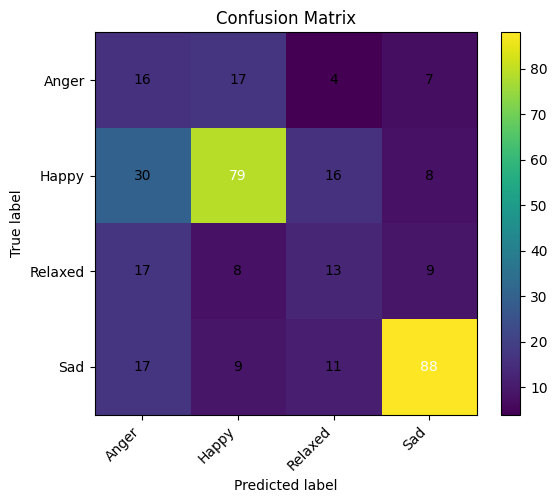

In [9]:
# Evaluation cell: confusion matrix, F1, precision, recall, etc.

# 1. Collect true labels and predictions from the test_dataset
y_true = []
y_pred = []

for batch_inputs, batch_labels in test_dataset:
    # Get predicted probabilities
    probs = model.predict(batch_inputs, verbose=0)
    # Convert to class indices
    preds = np.argmax(probs, axis=1)

    y_true.extend(batch_labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2. Basic metrics
acc = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print("=== Overall Metrics ===")
print(f"Accuracy      : {acc:.4f}")
print(f"F1 (macro)    : {f1_macro:.4f}")
print(f"F1 (weighted) : {f1_weighted:.4f}")

# 3. Classification report (per-class precision/recall/F1)
if 'label_encoder' in train_features:
    class_names = train_features['label_encoder'].classes_
else:
    # Fallback to numeric labels if encoder not available
    class_names = [str(i) for i in np.unique(y_true)]

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names))

# 4. Confusion matrix
cm = confusion_matrix(y_true, y_pred)

print("=== Confusion Matrix (raw) ===")
print(cm)

# 5. Optional: pretty plot of the confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, interpolation='nearest')
ax.set_title("Confusion Matrix")
plt.colorbar(im, ax=ax)

tick_marks = np.arange(len(class_names))
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.set_yticklabels(class_names)

ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")

# Annotate cells
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, cm[i, j],
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.tight_layout()
plt.show()


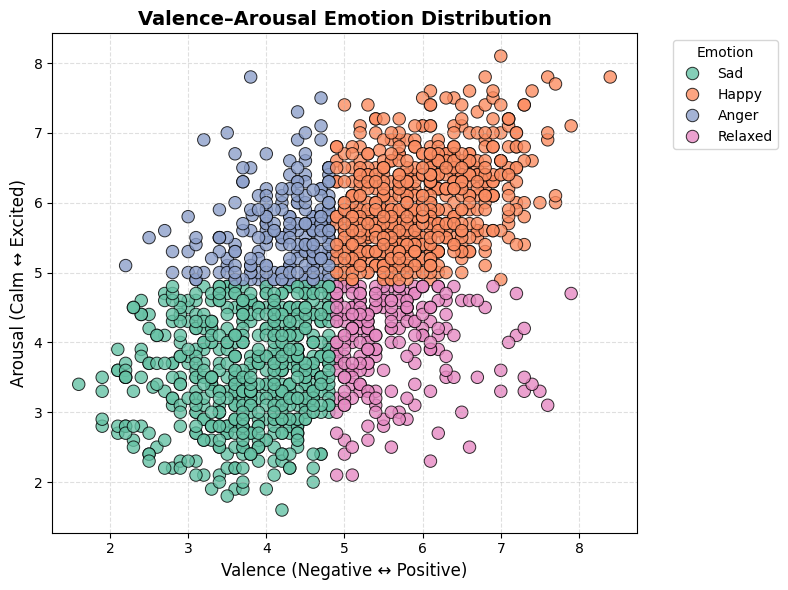

In [18]:
# Use the static annotations dataframe `df` which already contains valence_mean, arousal_mean and emotion.
# Rename song_id -> id for consistency if needed.
plot_df = df[['song_id', 'valence_mean', 'arousal_mean', 'emotion']].rename(columns={'song_id': 'id'})

# Clean any label whitespace
plot_df['emotion'] = plot_df['emotion'].astype(str).str.strip()

# --- Plot ---
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=plot_df,
    x='valence_mean',
    y='arousal_mean',
    hue='emotion',
    palette='Set2',
    s=80,
    edgecolor='k',
    alpha=0.8
)

plt.title('Valence–Arousal Emotion Distribution', fontsize=14, weight='bold')
plt.xlabel('Valence (Negative ↔ Positive)', fontsize=12)
plt.ylabel('Arousal (Calm ↔ Excited)', fontsize=12)
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()